## 1.Prepare environment and upload data

In [142]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import matplotlib.pyplot as plt

In [143]:
#upload data
train = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')

## 2. Exploratory data analysis

In [144]:
#see shape of data
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

In [145]:
details = rstr(train, 'SalePrice')
display(details.sort_values(by='corr SalePrice', ascending=False))

Data shape: (1460, 81)
___________________________
Data types:
 object     43
int64      35
float64     3
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,uniques,skewness,kurtosis,corr SalePrice
SalePrice,int64,1460,663,0,0.000,"[[208500, 181500, 223500, 140000, 250000, 1430...",1.883,6.536,1.000
OverallQual,int64,1460,10,0,0.000,"[[7, 6, 8, 5, 9, 4, 10, 3, 1, 2]]",0.217,0.096,0.791
GrLivArea,int64,1460,861,0,0.000,"[[1710, 1262, 1786, 1717, 2198, 1362, 1694, 20...",1.367,4.895,0.709
GarageCars,int64,1460,5,0,0.000,"[[2, 3, 1, 0, 4]]",-0.343,0.221,0.640
GarageArea,int64,1460,441,0,0.000,"[[548, 460, 608, 642, 836, 480, 636, 484, 468,...",0.180,0.917,0.623
...,...,...,...,...,...,...,...,...,...
PoolQC,object,7,4,1453,99.521,"[[nan, Ex, Fa, Gd]]",nan,nan,nan
Fence,object,281,5,1179,80.753,"[[nan, MnPrv, GdWo, GdPrv, MnWw]]",nan,nan,nan
MiscFeature,object,54,5,1406,96.301,"[[nan, Shed, Gar2, Othr, TenC]]",nan,nan,nan
SaleType,object,1460,9,0,0.000,"[[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con,...",nan,nan,nan


In [146]:
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10,6)

In [147]:
train.SalePrice.describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

In [148]:
#Check for skewness- measure of shape of the distribution of values

skew is: 1.8828757597682129


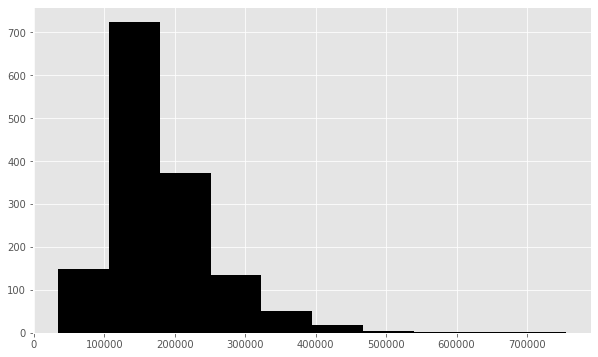

In [149]:
print("skew is:", train.SalePrice.skew())
plt.hist(train.SalePrice, color="black")
plt.show()

In [150]:
## longer tail to the right, distribution is positively skewed.
#Log transforming the target variable to improve linearity of data.


 new skew is : 0.12133506220520406


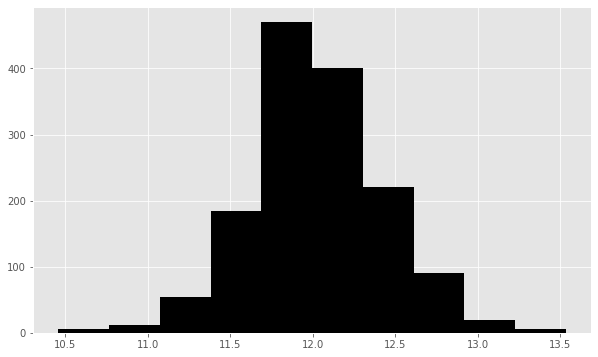

In [151]:
target = np.log(train.SalePrice)
print("\n new skew is :", target.skew())
plt.hist(target, color="black")
plt.show()

In [152]:
#new skew is closer to 0, skewness of data has been improved as seen in the plot above.
#Looks like a normal normal distribution :P

## 3. Feature Engineering

In [153]:
#view correlation(relationship) between columns

In [154]:
numeric_features = train.select_dtypes(include=[np.number])
corr = numeric_features.corr()
print("Most positively correlated with SalePrice")
print(corr['SalePrice'].sort_values(ascending=False)[:5], '\n')
print("Most negatively correlated with SalePrice")
print(corr['SalePrice'].sort_values(ascending=False)[-5:], '\n')

Most positively correlated with SalePrice
SalePrice     1.000
OverallQual   0.791
GrLivArea     0.709
GarageCars    0.640
GarageArea    0.623
Name: SalePrice, dtype: float64 

Most negatively correlated with SalePrice
YrSold          -0.029
OverallCond     -0.078
MSSubClass      -0.084
EnclosedPorch   -0.129
KitchenAbvGr    -0.136
Name: SalePrice, dtype: float64 



### a. Handling the outliers

In [155]:
#visualize relationship between garage area and SalePrice

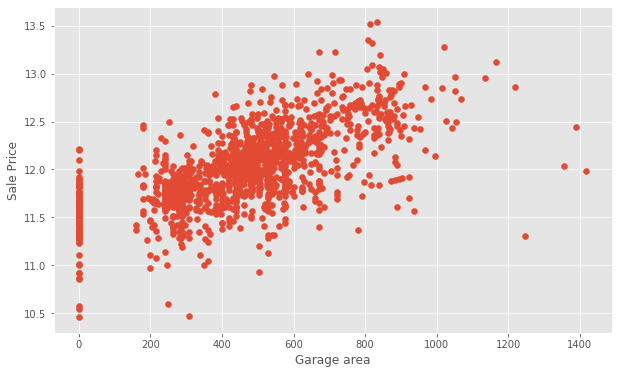

In [156]:
plt.scatter(x=train["GarageArea"], y=target)
plt.ylabel("Sale Price")
plt.xlabel("Garage area")
plt.show()

In [157]:
#Lots of homes with 0 garage. Outliers can affect a regression model by pulling the estimated regression line further
#away from the true population regression line. Removing some outliers from the dataset.

In [158]:
train = train[train["GarageArea"]<1200]

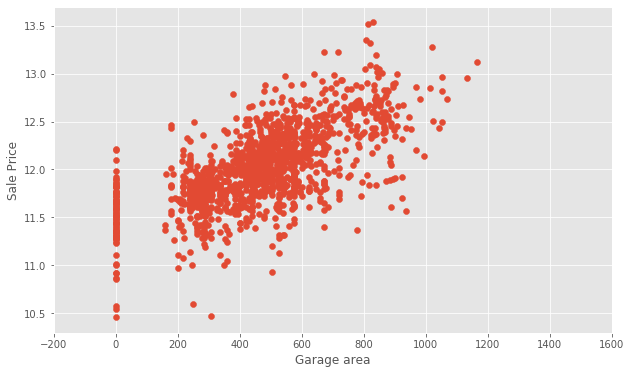

In [159]:
plt.scatter(x=train["GarageArea"], y=np.log(train.SalePrice))
plt.xlim(-200,1600) #force same scale as original
plt.ylabel("Sale Price")
plt.xlabel("Garage area")
plt.show()

### b. handling null values

In [160]:
#find top null columsn in training dataset

In [161]:
nulls = train.isnull().sum().sort_values(ascending=False)[:25]
nulls.columns = ["Null Count"]
nulls.index.name = "Feature"
print(nulls)

Feature
PoolQC          1449
MiscFeature     1402
Alley           1364
Fence           1174
FireplaceQu      689
LotFrontage      258
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
YearRemodAdd       0
MSSubClass         0
Foundation         0
ExterCond          0
ExterQual          0
dtype: int64


### c. wrangling the non-numeric features

In [162]:
categorical_features = train.select_dtypes(exclude=[np.number])
print(categorical_features.describe())

       MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      1455   1455    91     1455        1455      1455      1455   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       1147   1450    50      921        1309      1454      1048   

       LandSlope Neighborhood Condition1  ... GarageType GarageFinish  \
count       1455         1455       1455  ...       1374         1374   
unique         3           25          9  ...          6            3   
top          Gtl        NAmes       Norm  ...     Attchd          Unf   
freq        1378          225       1257  ...        867          605   

       GarageQual GarageCond PavedDrive PoolQC  Fence MiscFeature SaleType  \
count        1374       1374       1455      6    281          53     1455   
unique          5          5          3      3      4           4        9   
top            TA         TA      

### d. transforming features

In [163]:
#For most of these features, I'll use one hot encoding to unpack categorical variables
#Any transformations to training data will be applied to test data
#eg for Street column, call the transformed column enc_street which will be integers(1,0)

In [164]:
print("Before transformation")
print(train.Street.value_counts(), "\n")

Before transformation
Pave    1450
Grvl       5
Name: Street, dtype: int64 



In [165]:
train['enc_street'] = pd.get_dummies(train.Street, drop_first=True)
test['enc_street'] = pd.get_dummies(test.Street, drop_first=True)

In [166]:
print("After transformation")
print(train.enc_street.value_counts(), "\n")

After transformation
1    1450
0       5
Name: enc_street, dtype: int64 



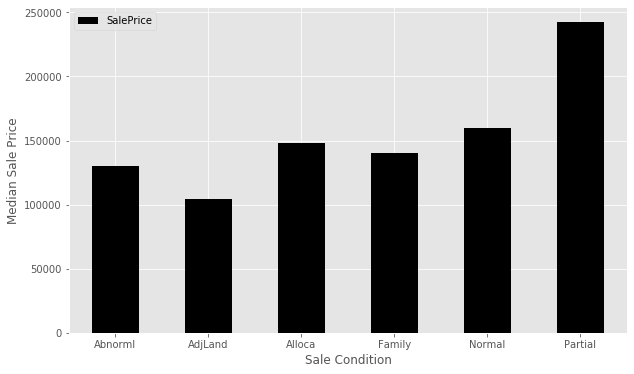

In [167]:
#analyze sale condition by plotting a pivot table
condition_pivot = train.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind="bar", color="black")
plt.xlabel("Sale Condition")
plt.ylabel("Median Sale Price")
plt.xticks(rotation=0) #set x axis labels to horizontal
plt.show()

In [168]:
## partial has a higher median price than the others, needs to be encoded as a feature
## to do this, we select all houses where SaleCondition is equal to Partial and assign a value of 1, otherwise 0

In [169]:
def encode(x): return 1 if x == 'Partial' else 0
train["enc_condition"] = train.SaleCondition.apply(encode)
test["enc_condition"] = test.SaleCondition.apply(encode)

In [170]:
#explore the new feature

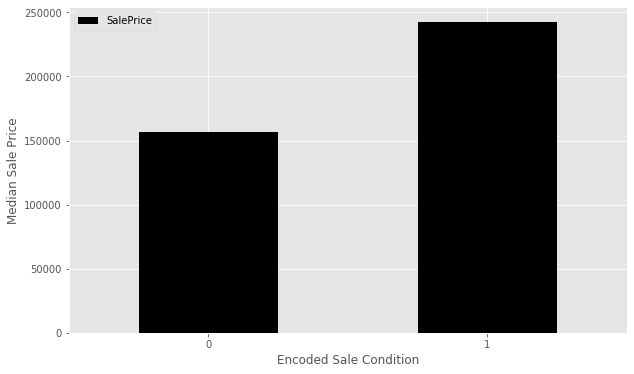

In [171]:
condition_pivot = train.pivot_table(index="enc_condition", values = "SalePrice", aggfunc=np.median)
condition_pivot.plot(kind="bar", color="black")
plt.xlabel("Encoded Sale Condition")
plt.ylabel("Median Sale Price")
plt.xticks(rotation=0) #set x axis labels to horizontal
plt.show()

## e. deal with missing values

In [172]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()
#verify there are no nulls
print(sum(data.isnull().sum()!=0))

0


## 4. Build a linear model

### a. X-y split

In [173]:
X = data.drop(["SalePrice", "Id"], axis = 1)
y = np.log(train["SalePrice"])

### b. data partitioning

In [174]:
#This helps evaluate model performance on unseen data, catch any scenarios of overfitting.
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.33)

### c. create linear regression model

In [175]:
lr = linear_model.LinearRegression()

In [176]:
model = lr.fit(x_train, y_train)

### e.  evaluate test performance

In [177]:
#R square
print("R^2 is :", model.score(x_test, y_test))

R^2 is : 0.8882477709262503


In [178]:
#Root mean sq error
prediction = model.predict(x_test)
rmse = mean_squared_error(y_test, prediction)
print("rmse is :",rmse)

rmse is : 0.017841794519568348


In [179]:
x_test.shape

(481, 38)

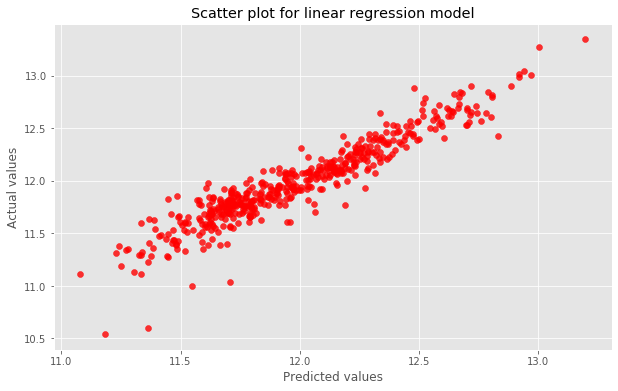

In [180]:
#using a scatter plot to view relationship
actual_values = y_test
plt.scatter(prediction, actual_values, alpha=.80, color = 'r')
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.title("Scatter plot for linear regression model")
plt.show()

## 5. Model augmentation

In [181]:
'''
* Using ridge regularization to decrease the influence of less important features by shrinking their coefficients.
* It takes a hyper-parameter alpha 
* Looping through a few values of alpha to see how the result changes
'''
print()

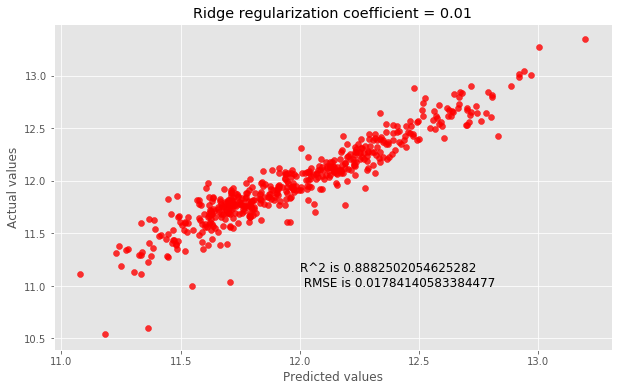

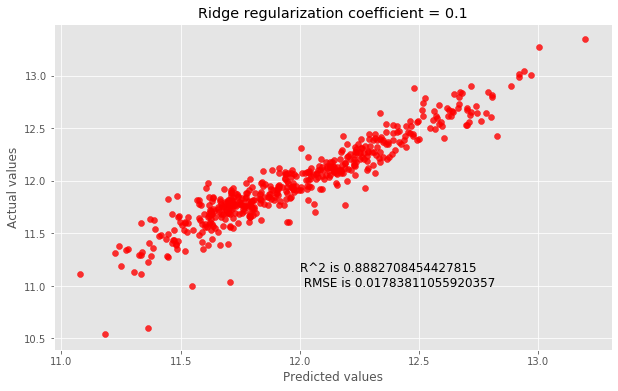

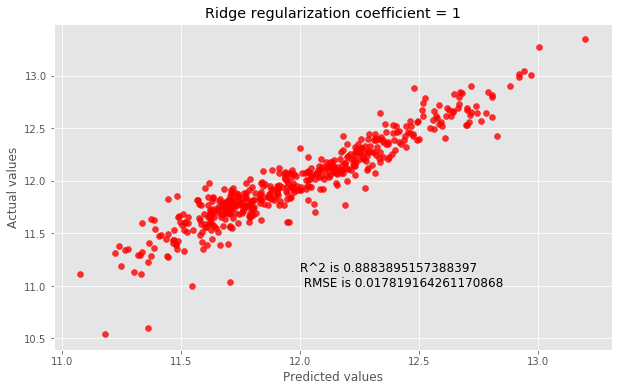

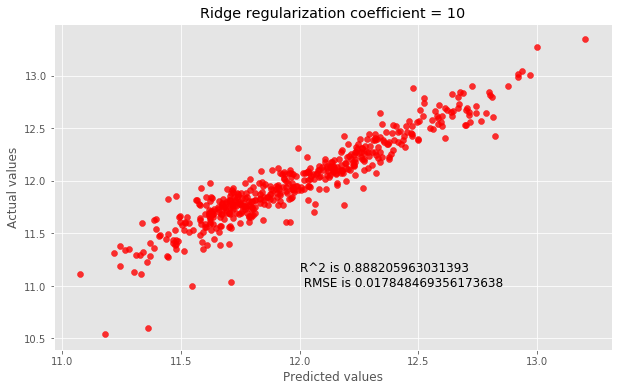

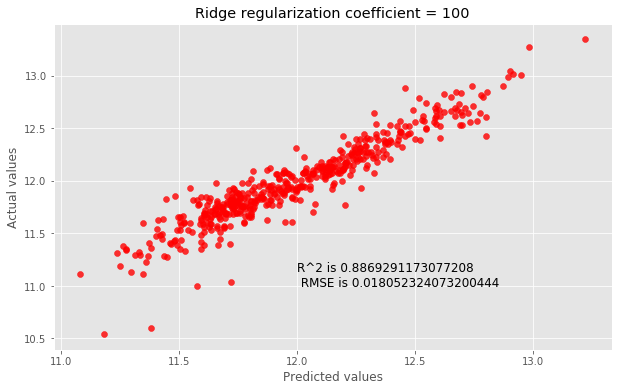

In [182]:
for i in range(-2,3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model=rm.fit(x_train, y_train)
    pred = ridge_model.predict(x_test)
    
    plt.scatter(pred, actual_values, alpha=.80, color = 'r')
    plt.xlabel("Predicted values")
    plt.ylabel("Actual values")
    plt.title("Ridge regularization coefficient = {}".format(alpha))
    overlay = 'R^2 is {}\n RMSE is {}'.format(ridge_model.score(x_test, y_test), mean_squared_error(y_test, pred))
    plt.annotate(s=overlay, xy=(12,11), size = 'large')
    plt.show()

In [183]:
# results show that adjusting the influence of features didn't susbtantially impact results.

## 6. Visualize results

### a.create csv with predicted SalePrice for each observation in test.csv

In [184]:
submission = pd.DataFrame()
submission['Id']= test.Id

#select the features freom the test data for the model
feats = test.select_dtypes(include=[np.number]).drop(['Id'], axis=1).interpolate()

In [185]:
predictions = model.predict(feats)

In [186]:
#transform predictions to the correct form
final_predictions = np.exp(predictions)

In [188]:
print("Original predictions are: \n ",predictions)
print("Final predictions are: \n ",final_predictions)

Original predictions are: 
  [11.76725362 11.71929504 12.07656074 ... 12.12505435 11.60734276
 12.39038938]
Final predictions are: 
  [128959.49172586 122920.74024358 175704.82598101 ... 184435.36303919
 109901.82646548 240479.31996392]


In [189]:
submission["SalePrice"] = final_predictions
submission.head()

,Id,SalePrice
0,1461,128959.492
1,1462,122920.740
2,1463,175704.826
3,1464,200050.833
4,1465,182075.470


In [191]:
#export to csv
submission.to_csv("data/submission.csv", index=False)